# Model training


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from monai import data, transforms
from swincell.utils.data_utils import flow_reshaped, split_dataset


/home/xzhang/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configure training parameters

In [16]:
from types import SimpleNamespace
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = SimpleNamespace(
    checkpoint=None,
    amp=False,
    batch_size=1,
    max_epochs=20,
    optim_lr=1e-5,
    model='swin',
    distributed=False,
    optimizer='adam',
    save_temp_img=False,
    downsample_factor =2, # downsample the input image if resolution is too high
    weight_decay=0.0001,
    use_flows=True,
    ROI=(64, 64, 32), 
    # ROI=(128, 128, 32), 
    workers=8,

)



In [17]:
# data folder
data_dir = '/data/download_data/colon_dataset/colon_30/' 
train_datalist, val_datalist = split_dataset(data_dir, split_ratios=[0.8,0.2])
print(len(train_datalist),len(val_datalist))




24 6


In [18]:

# img_shape = (129, 1030, 1300)
# img_shape = (512, 512,96)# nanolive XYZ
img_shape = (1300, 1030, 129) # colon 
img_reshape = (img_shape[0]//args.downsample_factor,img_shape[1]//args.downsample_factor,img_shape[2]//args.downsample_factor)
img_reshape = tuple(int(e) for e in img_reshape)
train_transform = transforms.Compose(
    [

        transforms.LoadImaged(keys=["image", "label"],ensure_channel_first=True),
        flow_reshaped(keys=["label"]),
        transforms.Resized(keys=["image", "label"],spatial_size=img_reshape),
        transforms.RandSpatialCropSamplesd(
            keys=["image","label"],
            roi_size=[args.ROI[0],args.ROI[1],args.ROI[2]],

            num_samples=1,
            random_center=True,
            random_size=False,
        ),

        transforms.ToTensord(keys=["image", "label"]),
    ]
)
valid_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.Resized(keys=["image", "label"],spatial_size=(512,512,96)),
        transforms.ScaleIntensityRanged(
            keys=["image"], a_min=21000, a_max=31000, b_min=0, b_max=1, clip=True
            # keys=["image"], a_min=300, a_max=400, b_min=0, b_max=1, clip=True
        ),
        transforms.ToTensord(keys=["image", "label"]),
    ]
)

train_ds = data.Dataset(data=train_datalist, transform=train_transform)
train_loader = data.DataLoader(
        train_ds, batch_size=1, num_workers=8, sampler=None, drop_last=True
    )
valid_ds = data.Dataset(data=val_datalist, transform=valid_transform)
valid_loader = data.DataLoader(
        valid_ds, batch_size=1, num_workers=8, sampler=None, drop_last=True
    )



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 64, 64, 32]) torch.Size([1, 4, 64, 64, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 64, 64, 32]) torch.Size([1, 4, 64, 64, 32])


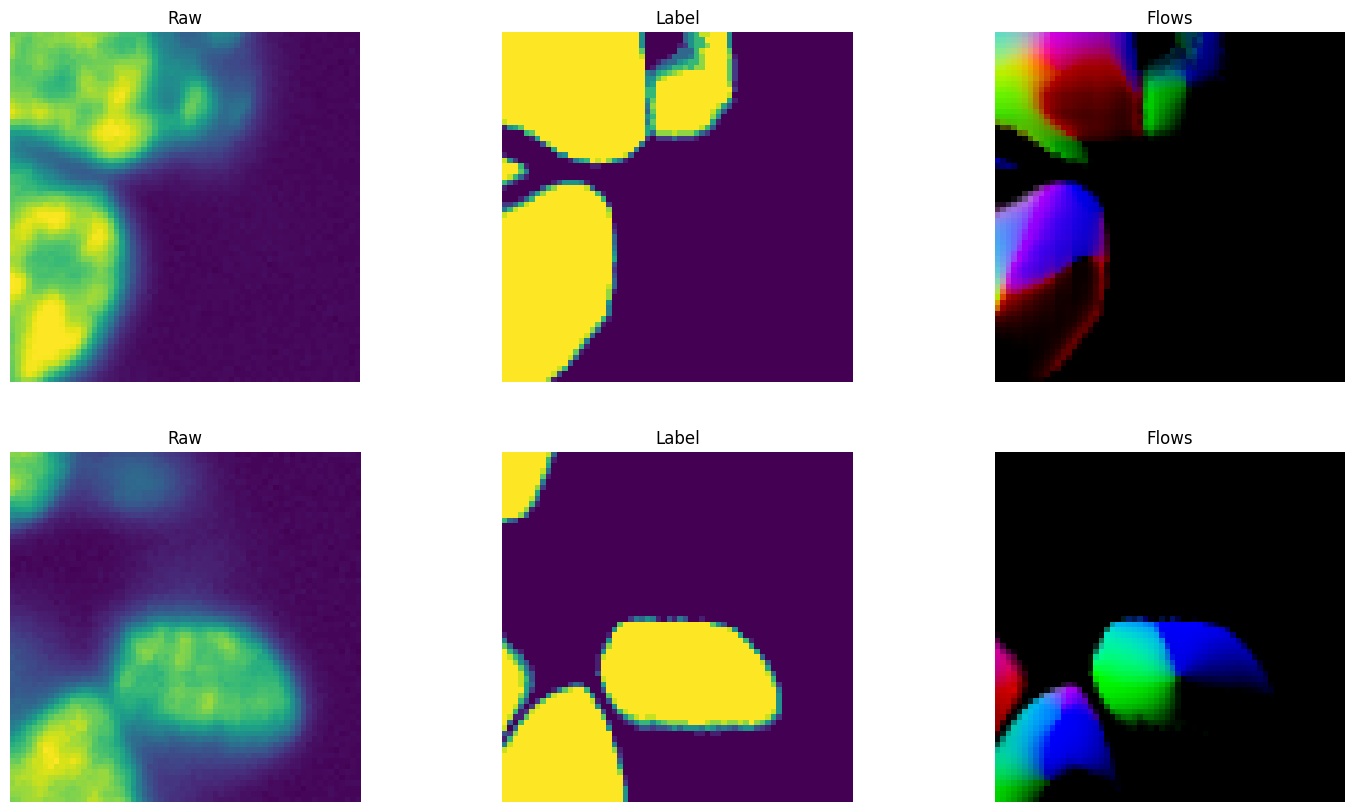

In [19]:
n_row = 2
fig, axes = plt.subplots(n_row, 3,sharex=False, sharey=False, figsize=(18,10))

slice2view = args.ROI[-1]//2
for i in range(n_row):
    datai = next(iter(train_loader))
    img2plot=datai['image']
    label2plot=datai['label']
    print(img2plot.shape, label2plot.shape)

    top= torch.max(img2plot[0,0,:,:,:],dim=-1)[0].detach().cpu()

    mask0= label2plot[0,0,:,:,slice2view].detach().cpu()
    # plot flows separately
    # flow1= label2plot[0,1,:,:,slice2view].detach().cpu()
    # flow2= label2plot[0,2,:,:,slice2view].detach().cpu()
    # flow3= label2plot[0,3,:,:,slice2view].detach().cpu()

    # one flow
    flow= label2plot[0,1:4,:,:,slice2view].detach().cpu().numpy().transpose(1, 2, 0)

    # print(mask0.max(),mask0.min())
    # print('mask2',mask2.max(),mask2.min())
    axes[i,0].imshow(img2plot[0,0,:,:,slice2view])
    axes[i,0].set_title('Raw')
    
    axes[i,1].imshow(mask0)
    axes[i,1].set_title('Label')
    axes[i,2].imshow(flow)
    axes[i,2].set_title('Flows')

    for col in range(3):
      axes[i,col].axis('off')



In [13]:
print(flow.shape)

torch.Size([3, 64, 64])


In [15]:
from monai.networks.nets import SwinUNETR
from swincell.utils.utils import AverageMeter
model = SwinUNETR(
            img_size=args.ROI,
            in_channels=1,
            out_channels=4,
            # feature_size=args.feature_size,
            feature_size=48,
            use_checkpoint=None,
        ).to(device)

from torch.nn import MSELoss,BCEWithLogitsLoss
from monai.losses import DiceLoss
loss1 = MSELoss(reduction='mean')
loss2 = DiceLoss(to_onehot_y=False, sigmoid=True)
losses = [loss1,loss2]

optimizer = torch.optim.Adam(model.parameters(), lr=args.optim_lr, weight_decay=1e-5)

In [16]:
from swincell.trainer import train_epoch
import time

train_losses = []
for epoch in range(args.max_epochs):
    epoch_time = time.time()
    train_loss, train_img_list = train_epoch(
            model, train_loader, optimizer, epoch=epoch, loss_func=losses, args=args
        )
    print(
                "Final training  {}/{}".format(epoch, args.max_epochs - 1),
                "loss: {:.4f}".format(train_loss),
                "time {:.2f}s".format(time.time() - epoch_time),
            )
    train_losses.append(train_loss)



Epoch 0/20 0/24 loss: 4.2566 time 18.57s
Epoch 0/20 1/24 loss: 4.1247 time 1.31s
Epoch 0/20 2/24 loss: 4.0423 time 0.32s
Epoch 0/20 3/24 loss: 3.9257 time 0.21s
Epoch 0/20 4/24 loss: 3.7934 time 0.22s
Epoch 0/20 5/24 loss: 3.6898 time 0.22s
Epoch 0/20 6/24 loss: 3.6258 time 0.21s
Epoch 0/20 7/24 loss: 3.5645 time 0.22s
Epoch 0/20 8/24 loss: 3.4720 time 15.12s
Epoch 0/20 9/24 loss: 3.3914 time 1.28s
Epoch 0/20 10/24 loss: 3.3400 time 1.48s
Epoch 0/20 11/24 loss: 3.2834 time 0.21s
Epoch 0/20 12/24 loss: 3.2306 time 0.21s
Epoch 0/20 13/24 loss: 3.1679 time 0.57s
Epoch 0/20 14/24 loss: 3.1265 time 0.88s
Epoch 0/20 15/24 loss: 3.0601 time 0.23s
Epoch 0/20 16/24 loss: 3.0284 time 11.38s
Epoch 0/20 17/24 loss: 3.0049 time 0.65s
Epoch 0/20 18/24 loss: 2.9598 time 2.69s
Epoch 0/20 19/24 loss: 2.9347 time 0.20s
Epoch 0/20 20/24 loss: 2.8930 time 0.20s
Epoch 0/20 21/24 loss: 2.8563 time 0.80s
Epoch 0/20 22/24 loss: 2.8091 time 0.53s
Epoch 0/20 23/24 loss: 2.7814 time 0.20s
Final training  0/19 lo

Text(0, 0.5, 'loss')

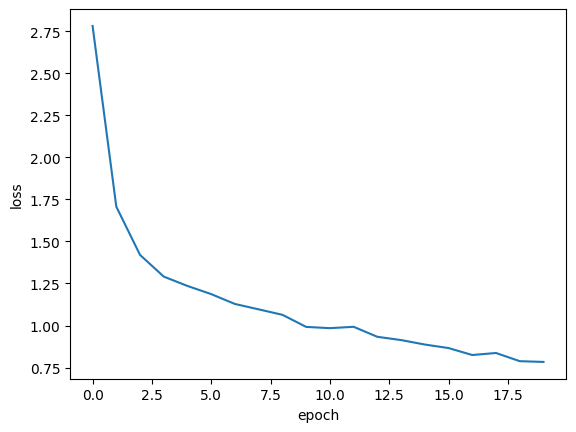

In [17]:
#plot loss
plt.plot(train_losses)
plt.xlabel('epoch')
plt.ylabel('loss')


In [24]:
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from functools import partial
from monai.transforms import Activations, AsDiscrete, Compose,FillHoles

model_path = 'model_final.pt'   #define model path
model = SwinUNETR(
    img_size=args.ROI,
    in_channels=1,
    out_channels=1,
    feature_size=48,
    use_checkpoint=False,
).cuda(0)
model_dict = torch.load(model_path)["state_dict"]
model.load_state_dict(model_dict)


model_inferer = partial(
    sliding_window_inference,
    roi_size=(96,96,96),
    # roi_size=(128,128,96),

    sw_batch_size=2,
    predictor=model,
    overlap=0.5,
)
post_sigmoid = Activations(sigmoid=True)
# post_pred = AsDiscrete(argmax=False, logit_thresh=1.01)
post_pred = AsDiscrete(argmax=False, threshold=0.6)



# print(val_output_convert.shape)


FileNotFoundError: [Errno 2] No such file or directory: 'model_final.pt'

# test inference

In [ ]:
post_trans = Compose([
    Activations(sigmoid=True),
    AsDiscrete(argmax=False, threshold=0.5),
    # RemoveSmallObjects(min_size = 100),
    FillHoles(applied_labels=None, connectivity=2)

])

with torch.no_grad():
        for idx, batch_data in enumerate(valid_loader):
            data_raw, target = batch_data["image"], batch_data["label"]
            data_raw, target = data_raw.cuda(0), target.cuda(0)
            # with autocast(enabled=True):
            logits = model_inferer(data_raw)
            # val_labels_list = decollate_batch(target)
            # val_outputs_list = decollate_batch(logits)
            print(logits.max(),logits.min())
            val_labels_list = target
            val_outputs_list = logits
            # val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            a = post_sigmoid(val_outputs_list)
            print('after sigmoid',a.max(),a.min(),a.median())
            val_output_convert1 = post_pred(post_sigmoid(val_outputs_list))
            val_output_convert2 = post_trans(logits)
            print(val_output_convert1.max(),val_output_convert1.min(),val_output_convert1.median())

In [86]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()